In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import subprocess

from utils import init_nodes
from spam_cluster import spam_requests_single

interval = 500
rps = 50

url = f"http://localhost:30888/predict"
USERS = 5
recordings = 50
time_step = 5

nodes = init_nodes(debug=True, custom_label='app=localization-api')

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi1:193.2.205.192, ca: 10.1.245.1, pods: [('localization-api1', 'localization-api', '10.1.245.44'), ('localization-api3', 'localization-api', '10.1.245.45')]
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.30')]



Scaling is run by a `.py` script

In [3]:
spam_process = subprocess.Popen(['python', 'spam_cluster.py', '--users', str(rps), '--interval', str(interval)])
mdqn_latenices = []
mdqn_container_recordings = []
for i in range(recordings):
    start_time = time.time()
    latencies = spam_requests_single(USERS, url)
    latencies = [latency for latency in latencies if latency is not None]
    mean_latency = np.mean(latencies)
    mdqn_latenices.append(mean_latency)

    node_recordings = []
    for node in nodes:
        for container_id, (_, _, _) in list(node.get_containers().items()):
            (cpu_limit, cpu, cpu_percentage), (_, _, _), (_, _) = node.get_container_usage(container_id)
            node_recordings.append((cpu_limit, cpu, cpu_percentage))
    mdqn_container_recordings.append(node_recordings)

    elapsed_time = time.time() - start_time
    time.sleep(max(0, time_step - elapsed_time))
spam_process.terminate()

In [4]:
spam_process = subprocess.Popen(['python', 'spam_cluster.py', '--users', str(rps), '--interval', str(interval)])
t_latencies = []
t_container_recordings = []
for i in range(recordings):
    start_time = time.time()
    latencies = spam_requests_single(USERS, url)
    latencies = [latency for latency in latencies if latency is not None]
    mean_latency = np.mean(latencies)
    t_latencies.append(mean_latency)

    node_recordings = []
    for node in nodes:
        for container_id, (_, _, _) in list(node.get_containers().items()):
            (cpu_limit, cpu, cpu_percentage), (_, _, _), (_, _) = node.get_container_usage(container_id)
            node_recordings.append((cpu_limit, cpu, cpu_percentage))
    t_container_recordings.append(node_recordings)
    
    elapsed_time = time.time() - start_time
    time.sleep(max(0, time_step - elapsed_time))
spam_process.terminate()

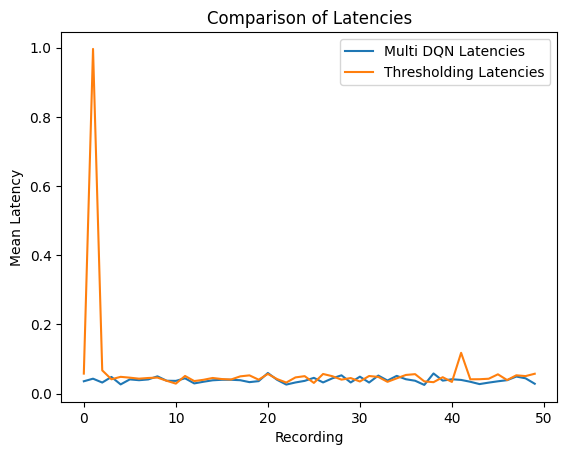

In [9]:
plt.plot(mdqn_latenices, label='Multi DQN Latencies')
plt.plot(t_latencies, label='Thresholding Latencies')

plt.xlabel('Recording')
plt.ylabel('Mean Latency')
plt.title('Comparison of Latencies')
plt.legend()

plt.show()

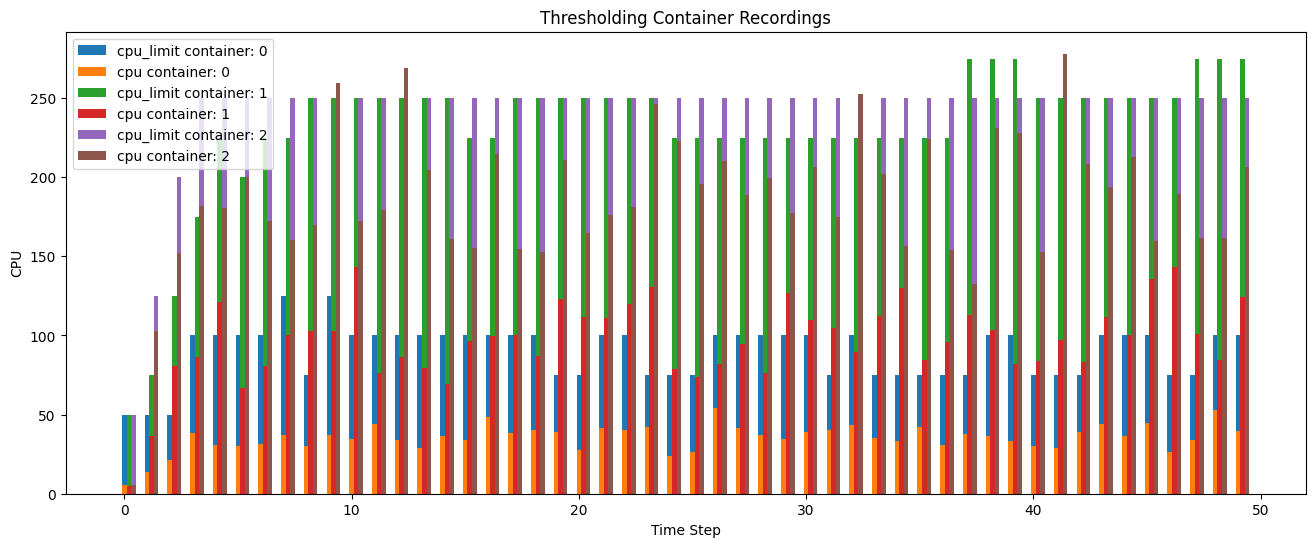

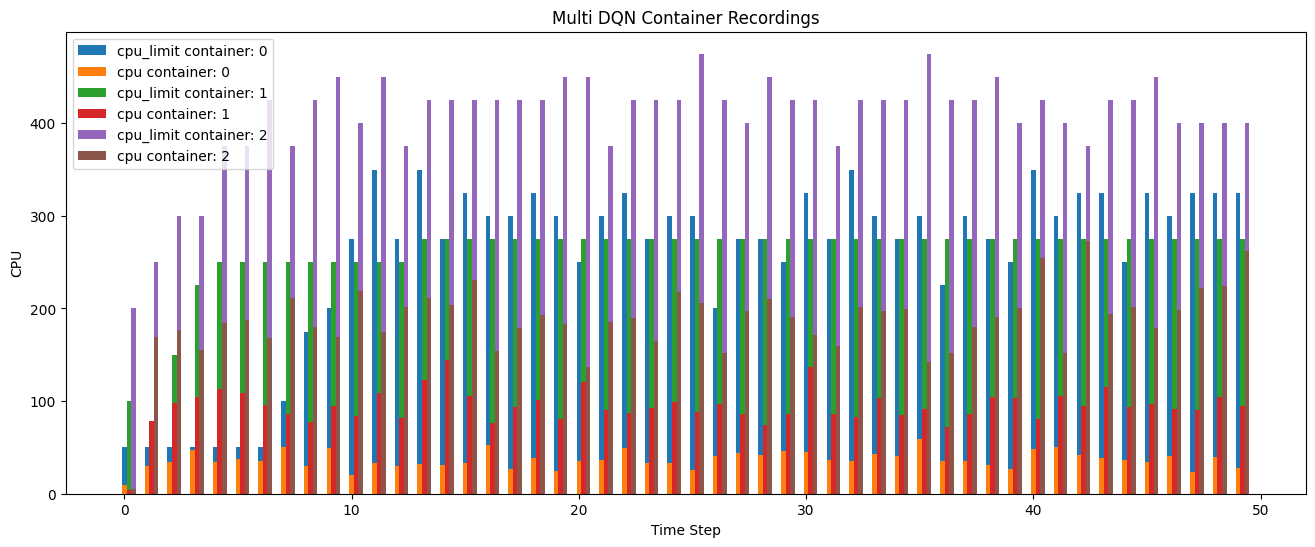

In [8]:
time_axis = range(len(t_container_recordings))

plt.figure(figsize=(16, 6))
for i, container_recordings in enumerate(zip(*t_container_recordings)):
    cpu_limits, cpu, _ = zip(*container_recordings)
    plt.bar(np.array(time_axis) + i*0.2, cpu_limits, width=0.2, label=f'cpu_limit container: {i}')
    plt.bar(np.array(time_axis) + i*0.2, cpu, width=0.2, label=f'cpu container: {i}')
plt.xlabel('Time Step')
plt.ylabel('CPU')
plt.title('Thresholding Container Recordings')
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
for i, container_recordings in enumerate(zip(*mdqn_container_recordings)):
    cpu_limits, cpu, _ = zip(*container_recordings)
    plt.bar(np.array(time_axis) + i*0.2, cpu_limits, width=0.2, label=f'cpu_limit container: {i}')
    plt.bar(np.array(time_axis) + i*0.2, cpu, width=0.2, label=f'cpu container: {i}')
plt.xlabel('Time Step')
plt.ylabel('CPU')
plt.title('Multi DQN Container Recordings')
plt.legend()
plt.show()